<h1>E-commerce via Computer Vision</h1>

## Raw Scrape of stanleytools.com - 1st Step

In [1]:
# ENVIRONMENT VARIABLES
PROJECT = 'hidden-layers-llc'
REGION  = 'us-east1'
BUCKET  = 'hidden-layers-llc'
MODULE = 'ai'
COMPONENT = 'images-raw'
GS = 'gs://'

In [2]:
%%bash
gcloud config set project hidden-layers-llc
gcloud config set compute/region us-east1

Updated property [core/project].
Updated property [compute/region].


In [4]:
# ONLY UNCOMMENT AND RUN THIS SCRIPT IF THIS IS THE 1ST NOTEBOOK OPENED IN THIS SESSION
#!bash install_scrape_libs.sh

In [27]:
# import necessary libraries
import time
import os
import requests
from bs4 import BeautifulSoup, SoupStrainer, NavigableString, Comment, Tag
import csv
from copy import deepcopy
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import pandas as pd
import pickle as pkl
from shutil import copy2
import xmltodict

In [6]:
# GLOBAL VARIABLES FOR THIS SITE
# create search combinations
cats = ['Adjustable Wrenches', 'Adjustable Wrench Set']
brand = 'Stanley'
search_entries = [brand+' '+cat for cat in cats] # list of normal-Engligh search terms
# known (from Chrome inspection) pre-product-specific page URL path
path_ok = 'https://www.stanleytools.com/products/automotive-tools/other-tools/wrenches-set/'
sitemap_url = 'https://www.stanleytools.com/sitemap.xml'
prod_page_list = [] # list to capture all the individual product pages 
prod_page_descrs = [] # list to capture all the individual product pages' end strings (the product description of such a page)
# desired data field for each image
desired_fields = ['img_no', 'manufacturer', 'description', 'retailer_sku', 'manufacturer_sku', 'img_url', 'img_name']
base_url = 'https://www.stanleytools.com'  # set the base_url
site_initials = 'SNY' # create the initials/abbreviation to identify the site
curr_dir = os.getcwd() # set the current directory in which this notebook resides
# create file descriptor (name) for the csv file to which data will be persisted
fid_ProdPages = site_initials+'_'+'scrape'+'_'+'ProdPages'+'.csv' # for the product pages searched next

In [7]:
#retrieve summaries from target site scrape
copy2('../df_pages_CLEAN_pkl.pickle', '.')
copy2('../dir_paths.pickle', '.')
copy2('../brand_dictionary_pkl.pickle', '.')

'./brand_dictionary_pkl.pickle'

In [8]:
# Load the summary DataFrame to limit to this site
with open('df_pages_CLEAN_pkl.pickle', 'rb') as df_pp:
  df_pages = pkl.load(df_pp)

In [9]:
# Load the path details saved from target site scrape
with open('dir_paths.pickle', 'rb') as df_paths:
  home_dir = pkl.load(df_paths)
  project_folder = pkl.load(df_paths)
  target_site_folder = pkl.load(df_paths)
  images_folder = pkl.load(df_paths)
  images_train_folder = pkl.load(df_paths)
  images_validation_folder = pkl.load(df_paths)
  images_test_folder = pkl.load(df_paths)
  classes = pkl.load(df_paths)

In [10]:
# Load the brand_dict saved from target site scrape
with open('brand_dictionary_pkl.pickle', 'rb') as brand_dict_fid:
  brand_dict = pkl.load(brand_dict_fid)

In [11]:
# set headers
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)'\
           'AppleWebKit 537.36 (KHTML, like Gecko) Chrome',
           'Accept':'text/html,application/xhtml+xml,application/xml;'\
           'q=0.9,image/webp,*/*;q=0.8'}

In [12]:
# Limit search for this site
site_idxs = brand_dict[brand][1]
df_model_rows = df_pages.loc[df_pages['img_no'].map(lambda x: x in site_idxs)]
models = df_model_rows['manufacturer_sku'].tolist()

In [59]:
df_model_rows.head(10)

,img_no,manufacturer,description,retailer_sku,manufacturer_sku,img_url,img_name
0,0,Stanley,87-471-adjustable-wrench-10-inch-long,SNY_87-471,87-471,https://images.globalindustrial.com/images/275...,SNY_87-471.jpg
1,1,Stanley,87-473-adjustable-wrench-12-inch-long,SNY_87-473,87-473,https://images.globalindustrial.com/images/275...,SNY_87-473.jpg
2,2,Stanley,87-367-adjustable-wrench-6-inch-long,SNY_87-367,87-367,https://images.globalindustrial.com/images/275...,SNY_87-367.jpg
3,3,Stanley,90-950-bi-material-adjustable-wrench-12-inch-long,SNY_90-950,90-950,https://images.globalindustrial.com/images/275...,SNY_90-950.jpg
4,4,Stanley,87-369-adjustable-wrench-8-inch-long,SNY_87-369,87-369,https://images.globalindustrial.com/images/275...,SNY_87-369.jpg
5,5,Stanley,90-948-bi-material-adjustable-wrench-8-inch-long,SNY_90-948,90-948,https://images.globalindustrial.com/images/275...,SNY_90-948.jpg
6,6,Stanley,90-949-bi-material-adjustable-wrench-10-inch-long,SNY_90-949,90-949,https://images.globalindustrial.com/images/275...,SNY_90-949.jpg
7,7,Stanley,85-762-cushion-grip-adjustable-wrench-10-inch-...,SNY_85-762,85-762,https://images.globalindustrial.com/images/275...,SNY_85-762.jpg
8,8,Stanley,85-610-locking-adjustable-wrench-10-inch-long,SNY_85-610,85-610,https://images.globalindustrial.com/images/275...,SNY_85-610.jpg


In [13]:
# define a function to retrieve the sitemap
def get_sitemap():
  global headers
  global sitemap_url
  session = requests.Session() # Pg. 219
  url = sitemap_url
  req = session.get(url, headers=headers)
  sitemap_txt = req.text

  return sitemap_txt

In [14]:
# define a function to parse for the overall site_dict and the specific site_pages
def parse_sitemap_txt(sitemap_txt):
  global models
  site_dict = xmltodict.parse(sitemap_txt)
  site_pages = [[row['loc'], row['lastmod']] for row in site_dict['urlset']['url']]
  df_site = pd.DataFrame(site_pages, columns=["page_node", "last_modified"])
  df_brand = df_site.loc[df_site['page_node'].map(lambda url: url.rsplit('/')[-1] in models)]
  page_urls = df_brand['page_node'].tolist()
  
  return site_dict, site_pages, df_site, df_brand, page_urls

In [15]:
# define a function to retrieve a product page
def get_prod_page_txt(page_url):
  global headers
  session = requests.Session() # Pg. 219
  url = page_url
  req = session.get(url, headers=headers)
  prod_page_txt = req.text
  
  return prod_page_txt

In [16]:
# define a function to parse for the overall site_dict and the specific site_pages
def get_image_url(prod_page_txt):
  global headers
  global base_url
  bs=BeautifulSoup(prod_page_txt, 'html.parser')
  img_link = bs.find('a', {'class':'easyzoom__full-image-link'})
  img_href = img_link['href']
  img_url = base_url + img_href
  
  return img_url

In [17]:
# define a function to get and save product image source
def get_image(img_url, page_url):
  global headers
  global brand
  global df_model_rows
  session =requests.Session() # Pg. 219
  url = img_url
  req = session.get(url, headers=headers)
  i = Image.open(BytesIO(req.content)) #PIL uses RGB color scheme
  page_url_copy = deepcopy(page_url)
  page_suffix = page_url_copy.rsplit('/', 1)[-1]
  retailer_sku = site_initials+'_'+page_suffix
  img_no = df_model_rows.loc[df_model_rows['retailer_sku'] == retailer_sku].index[0]
  img_name = brand+'_'+page_suffix+'.jpg'
  try:
    i.save(img_name)
  except IOError:
    print('Could not save file {} - continuing on'.format(img_name))
    img_name = None
  
  return img_no, img_name

In [18]:
# define a function to update df_model_rows
def update_df_model_rows(img_no, img_name):
  global df_model_rows
  df_model_rows.ix[img_no, 'img_no'] = img_no
  df_model_rows.ix[img_no, 'img_name'] = img_name
  print('Just inserted into row: {} image: {}'.format(img_no, img_name))

In [19]:
# run the searches
sitemap_txt = get_sitemap()
time.sleep(20)
site_dict, site_pages, df_site, df_brand, page_urls = parse_sitemap_txt(sitemap_txt)
time.sleep(20)
for page_url in page_urls:
  prod_page_txt = get_prod_page_txt(page_url)
  img_url = get_image_url(prod_page_txt)
  time.sleep(20)
  img_no, img_name = get_image(img_url, page_url)
  update_df_model_rows(img_no, img_name)
  time.sleep(20)

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/envs/py3env/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Just inserted into row: 2 image: Stanley_87-367.jpg
Just inserted into row: 0 image: Stanley_87-471.jpg
Just inserted into row: 1 image: Stanley_87-473.jpg
Just inserted into row: 5 image: Stanley_90-948.jpg
Just inserted into row: 6 image: Stanley_90-949.jpg
Just inserted into row: 3 image: Stanley_90-950.jpg
Just inserted into row: 4 image: Stanley_87-369.jpg
Just inserted into row: 7 image: Stanley_85-762.jpg
Just inserted into row: 8 image: Stanley_85-610.jpg


In [21]:
display(df_model_rows)

,img_no,manufacturer,description,retailer_sku,manufacturer_sku,img_url,img_name
0,0,Stanley,87-471-adjustable-wrench-10-inch-long,SNY_87-471,87-471,https://images.globalindustrial.com/images/275...,Stanley_87-471.jpg
1,1,Stanley,87-473-adjustable-wrench-12-inch-long,SNY_87-473,87-473,https://images.globalindustrial.com/images/275...,Stanley_87-473.jpg
2,2,Stanley,87-367-adjustable-wrench-6-inch-long,SNY_87-367,87-367,https://images.globalindustrial.com/images/275...,Stanley_87-367.jpg
3,3,Stanley,90-950-bi-material-adjustable-wrench-12-inch-long,SNY_90-950,90-950,https://images.globalindustrial.com/images/275...,Stanley_90-950.jpg
4,4,Stanley,87-369-adjustable-wrench-8-inch-long,SNY_87-369,87-369,https://images.globalindustrial.com/images/275...,Stanley_87-369.jpg
5,5,Stanley,90-948-bi-material-adjustable-wrench-8-inch-long,SNY_90-948,90-948,https://images.globalindustrial.com/images/275...,Stanley_90-948.jpg
6,6,Stanley,90-949-bi-material-adjustable-wrench-10-inch-long,SNY_90-949,90-949,https://images.globalindustrial.com/images/275...,Stanley_90-949.jpg
7,7,Stanley,85-762-cushion-grip-adjustable-wrench-10-inch-...,SNY_85-762,85-762,https://images.globalindustrial.com/images/275...,Stanley_85-762.jpg
8,8,Stanley,85-610-locking-adjustable-wrench-10-inch-long,SNY_85-610,85-610,https://images.globalindustrial.com/images/275...,Stanley_85-610.jpg


In [23]:
# Now let's capture some essentials before persisting images to train sudirectory
current_folder = deepcopy(os.getcwd())
current_dir_contents = os.listdir(current_folder)
img_fids = [fid for fid in current_dir_contents if fid.endswith('.jpg')]
mode = images_train_folder
classes = [fid.replace(brand, site_initials).rstrip('.jpg') for fid in img_fids]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


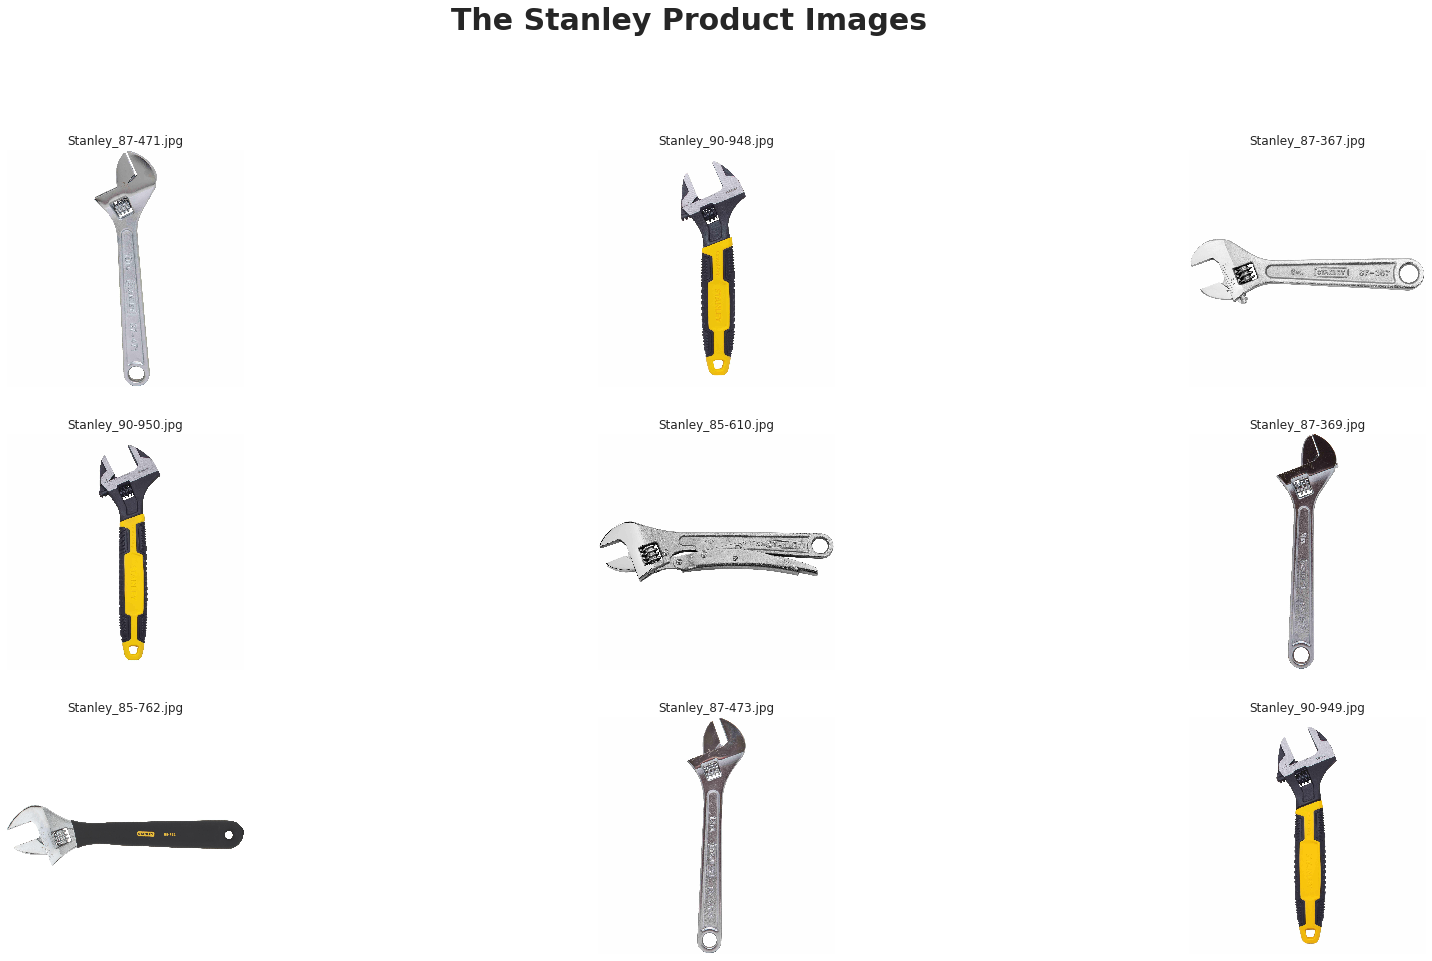

In [28]:
# Now, let's view those images
#plt.clf()  # No need to call this now, as last plot didn't call .show()
images_sample = []
img_tags = []

for img_name in img_fids:
  img=cv2.imread(img_name) # Use cv2.imread, which doesn't change color scheme
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Site's images in BGR
  images_sample.append(img)
  img_tags.append(img_name)

sample_cnt = len(images_sample)

plt.figure(figsize=(30,20))
plt.suptitle('The Stanley Product Images', fontsize=30, weight='bold')
for i in range(sample_cnt):
    plt.subplot(431 + i)
    plt.title(img_tags[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_sample[i])

plt.show()

In [29]:
# Let's check some metadata for each sampled image to know what we have
for img_no, image in enumerate(images_sample):
  print('for img_no: {} the shape is: {}'.format(img_no, image.shape))
  print('for img_no: {} the type is: {}'.format(img_no, type(image)))

for img_no: 0 the shape is: (3000, 3000, 3)
for img_no: 0 the type is: <class 'numpy.ndarray'>
for img_no: 1 the shape is: (3000, 3000, 3)
for img_no: 1 the type is: <class 'numpy.ndarray'>
for img_no: 2 the shape is: (3000, 3000, 3)
for img_no: 2 the type is: <class 'numpy.ndarray'>
for img_no: 3 the shape is: (3000, 3000, 3)
for img_no: 3 the type is: <class 'numpy.ndarray'>
for img_no: 4 the shape is: (3000, 3000, 3)
for img_no: 4 the type is: <class 'numpy.ndarray'>
for img_no: 5 the shape is: (3000, 3000, 3)
for img_no: 5 the type is: <class 'numpy.ndarray'>
for img_no: 6 the shape is: (3000, 3000, 3)
for img_no: 6 the type is: <class 'numpy.ndarray'>
for img_no: 7 the shape is: (3000, 3000, 3)
for img_no: 7 the type is: <class 'numpy.ndarray'>
for img_no: 8 the shape is: (3000, 3000, 3)
for img_no: 8 the type is: <class 'numpy.ndarray'>


In [31]:
# save off the cleaned, FINAL DataFrame
with open('df_Stanley_CLEAN_pkl.pickle', 'wb') as df_pages_clean:
    pkl.dump(df_model_rows, df_pages_clean, protocol=pkl.HIGHEST_PROTOCOL)

In [32]:
for pic_class, fid in zip(classes, img_fids):
  copy2(fid, os.path.join('..', mode, pic_class))

## On to the next site to build our database